# Тестовое задание

```
- Задача: Классификация изображений с фреймфорком глубокого обучения Pytorch используя архитектуры CNN.
- Данные: https://www.kaggle.com/puneet6060/intel-image-classification
- Github: https://github.com/Odilbek99/intel-image-classification-resnet
- Кандидат: Умаралиев Одилбек Отабекович
- Университет: Университет Иннополис
- Образование: Степень магистра по направлению Data Science и ИИ
- Интересы: ML/DL/CV/NLP
- Telegram: https://t.me/odilee7
- Linkedin: https://www.linkedin.com/in/odilbek-umaraliev-59b970252/
``` 
<hr>


In [ ]:
# !unzip '/content/drive/MyDrive/Intel Image Classification/archive.zip'

# **Импортирование библиотек**

In [2]:
# Импортирование необходимых библиотек

import os

import torch
import torch.nn as nn
from torchvision import transforms, datasets

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Архитектура ResNET

Архитектура *ResNet*. Архитектура *ResNet* вводит **"пропускные связи"** (также известные как ***residual network***), что позволяет обучать гораздо более глубокие сети.

В данной реализации мы имеем простую сеть *ResNet*, состоящую из нескольких блоков *ResidualBlock*. Каждый блок ResidualBlock имеет два сверточных слоя и дополнительный слой понижающей выборки.

In [3]:
# Класс ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Класс ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # Создание слоев ResNet
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, stride=stride, 
                          padding=1, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Обработка данных
Обработка данных состоит из следующих:


1.   Загрузка данных
2.   Разделение данных на обучающий и проверочный наборы
3. Создание загрузчики данных



## Загрузка данных

In [4]:
# Путь к папке
DATA_PATH = '/content/' # Не забудьте поменять путь, я моунтировал гугл диск 

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка данных
dataset = datasets.ImageFolder(os.path.join(DATA_PATH, 'seg_train/seg_train'), transform=transform)

## Разделение данных на обучающий и проверочный наборы

In [5]:
# Разделение данных на обучающий и проверочный наборы
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

## Создание загрузчики данных

In [6]:
# Создание загрузчики данных (Даталоадеров)
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, 'seg_test/seg_test'), transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Обучение модели

##  Гиперпараметры (Hyperparameter tuning)

In [7]:
# !!! Рекоммендуется использовать GPU для тренировки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Гиперпараметры
epochs = 24
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

## Инициализация параметров и обучение

In [8]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, 
                                                steps_per_epoch=len(train_loader), 
                                                epochs=epochs)


In [9]:
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward 
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward propagation и оптимизация
        optimizer.zero_grad()
        loss.backward()
        # Обрезка градиента (Gradient clipping)
        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Точность модели на валидационных изображениях: {} %'.format(100 * correct / total))


Точность модели на валидационных изображениях: 54.07908799429996 %
Точность модели на валидационных изображениях: 61.91663697898112 %
Точность модели на валидационных изображениях: 62.4153900961881 %
Точность модели на валидационных изображениях: 66.65479159244745 %
Точность модели на валидационных изображениях: 72.3548272176701 %
Точность модели на валидационных изображениях: 72.31920199501246 %
Точность модели на валидационных изображениях: 75.846099038119 %
Точность модели на валидационных изображениях: 82.40114000712505 %
Точность модели на валидационных изображениях: 73.20983256145351 %
Точность модели на валидационных изображениях: 80.29925187032418 %
Точность модели на валидационных изображениях: 80.15675097969363 %
Точность модели на валидационных изображениях: 81.83113644460278 %
Точность модели на валидационных изображениях: 81.26113288208052 %
Точность модели на валидационных изображениях: 83.57677235482721 %
Точность модели на валидационных изображениях: 79.40862130388315 %

In [10]:
# Сохранение модели
torch.save(model.state_dict(), 'model_resnet.pth')

# Результаты и Заключение

## Результат

In [11]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print('Точность модели на тестовых изображениях:: {} %'.format(100 * correct / total))

Точность модели на тестовых изображениях:: 84.43333333333334 %


In [12]:
# Classification Report
print("Classification Report: \n", classification_report(all_labels, all_predictions))

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       437
           1       0.93      0.95      0.94       474
           2       0.80      0.77      0.78       553
           3       0.80      0.79      0.79       525
           4       0.83      0.87      0.85       510
           5       0.85      0.87      0.86       501

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.84      0.84      0.84      3000



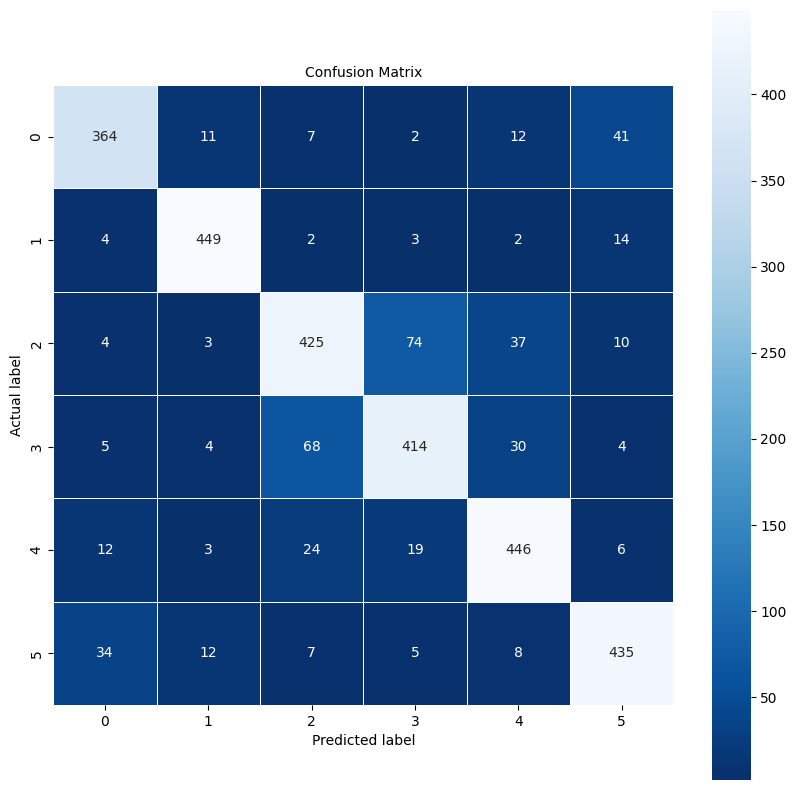

In [13]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 10);


## Заключение

В используется архитектура *ResNet* (*Residual Network*) - конволюционная нейронная сеть, известная как "skip connections". Эта модель известна тем, что позволяет обучать глубокие сети.

Модель *ResNet* строится из блоков ResidualBlock. Каждый блок имеет два сверточных слоя и дополнительный слой понижающей выборки.

Используется набор данных [*Intel Image Classification*](https://www.kaggle.com/puneet6060/intel-image-classification) от Kaggle. Он включает изображения, классифицированные по шести различным классам. Перед подачей в модель изображения изменяются в размере и нормализуются.

Для обучения используется оптимизатор *Adam*, вариант стохастического градиентного спуска, с одноцикловой политикой скорости обучения и обрезанием градиента для управления величиной обновления градиента.

Производительность модели оценивается с помощью точности, прецизионности, отзыва и *F1-score*, как показано в отчете о классификации. Кроме того, матрица путаницы дает наглядное представление о работе модели.

На тестовом наборе модель достигла точности 85%. Модель еще можно улучшить, используя более сложную версию ResNet, точную настройку гиперпараметров или применяя методы расширения данных.